#**IBM Research: Ponder This**
##May 2023: Computing Quadratic Forms
https://research.ibm.com/haifa/ponderthis/challenges/May2023.html

This problem was suggested by Lorenzo Gianferrari Pini and Radu-Alexandru Todor - thanks!

Let $x\in\mathbb{R}^n$ be a length $n$ vector $(x_0, x_1, \ldots, x_{n-1})$ and $A\in\mathbb{R}^{n\times n}$ be an $n\times n$ matrix. We seek to compute the quadratic form $x^TAx$.

Assume $x$ is equally spaced between $-1$ and $1$ , e.g., for $n=5$ , we have

$x = (-1, -0.5, 0, 0.5, 1)$

The matrix $A$ is generated in the following manner:

Let $k\in\mathbb{N}$ be a natural number and define a vector $a\in\mathbb{R}^{2^k}$ that is equally spaced between 0 and 1 , i.e., $a_t =\frac{t}{2^k-1}$ for $t=0,1,\ldots,2^k-1$ . The values of $A$ will be taken from the vector a in the following manner:

We are given a sequence $Q_0, Q_1,\ldots, Q_{n-1}$ , with each $Q_i\in\mathbb{N}^k$ being a vector of k natural numbers. Given two such vectors, define $Q_i==Q_j$ as the binary vector of length k that has $1$s in the entries that are equal in $Q_i, Q_j$ and $0$s in the other entries. Let $[Q_i==Q_j]$ be the natural number whose binary representation is $Q_i==Q_j$ , where the least significant bit is on index $0$. For example, if

$Q_i = (1, 5, 7, 8)$

$Q_j = (2, 5, 6, 8)$

Then
$Q_i==Q_j = (0, 1, 0, 1)$

And
$[Q_i==Q_j] = 10$ (since the vector $(0, 1, 0, 1)$ stands for the binary representation $1010$).

Now define $A_{ij} = a_{[Q_i==Q_j]}$ .

So one can think of $A_{ij}$ as taking on a value from a fixed list of $2^k$ values based on the "similarity" between $Q_i$ and $Q_j$ .

The values of the $Q_i$ 's are chosen pseudo-randomly using the formula

$Q_i[t] = \left\lfloor2^k\cdot (\sin((i+1)\cdot (t+1))-\left\lfloor \sin((i+1)\cdot (t+1))\right\rfloor )\right\rfloor$

For example, if $k=5$ , then $Q_{13}=(31, 8, 2, 15, 24)$

Your goal: Find $x^TAx$ (rounded to three decimals) for $k=5, n=2^{20}$ .

A bonus "*" will be given for finding $x^TAx$ (rounded to three decimals) for $k=5, n=2^{30}$ .


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

n = 2**20
k = 5
def Q(i):
  assert i < n
  l = []
  for t in range(k):
    x = math.sin((i+1)*(t+1))
    x = math.floor(2**k*(x - math.floor(x)))
    l.append(x)
  return l
def binv(l1,l2):
  assert len(l1) == len(l2)
  sum = 0
  for i in range(len(l1)): sum += (2**i)*(l1[i]==l2[i])
  return sum
print(Q(13))
print(Q(7))
print(binv(Q(13),Q(7)))

[31, 8, 2, 15, 24]
[31, 22, 3, 17, 23]
1


We start solving the problem by writing some preliminary helper functions to make use of.

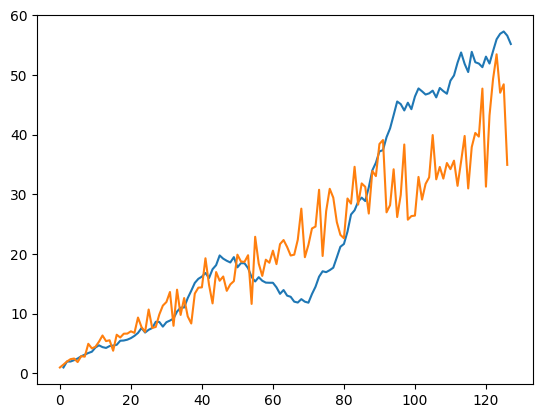

In [ ]:
# Exploratory analysis
# Questions: How closely do the values generated pseudo-randomly produce results similar to that of actually random values?
ns = []
outputs = []
randOutputs = []
for n in range(1,2**7):
  Qs = []
  QsRandom = []
  for i in range(n):
    Qs.append(Q(i))
    QsRandom.append(np.floor(np.random.rand(5)*2**k))
  B = np.zeros((n,n))
  A = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      A[i][j] = binv(Qs[i],Qs[j])
      B[i][j] = binv(QsRandom[i],QsRandom[j])
  x = np.linspace(-1,1,n)
  outputs.append(x.T@A@x/(2**k-1))
  randOutputs.append(x.T@B@x/(2**k-1))
  ns.append(n)
plt.plot(ns,outputs)
plt.plot(randOutputs)

[2.0, 2.2222222222222223, 3.4233048057932844, 4.7985663082437275, 9.193447685542612, 13.03557408626533, 54.08313616627233, 82.49585494412818, 20.29447403632305, 127.53641418441346]


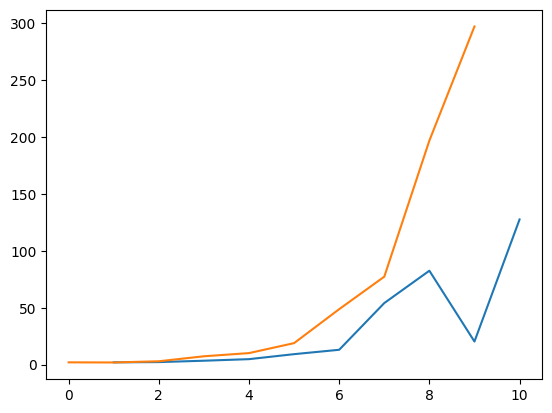

In [ ]:
pows = []
outputs = []
randOutputs = []
for pow in range(1,11):
  n = 2**pow
  Qs = []
  QsRandom = []
  for i in range(n):
    Qs.append(Q(i))
    QsRandom.append(np.floor(np.random.rand(5)*2**k))
  B = np.zeros((n,n))
  A = np.zeros((n,n))
  for i in range(n):
    A[i][i] = 2**k-1
    B[i][i] = 2**k-1
    for j in range(i+1,n):
      A[i][j] = binv(Qs[i],Qs[j])
      B[i][j] = binv(QsRandom[i],QsRandom[j])
      A[j][i] = A[i][j]
      B[j][i] = B[i][j]
  x = np.linspace(-1,1,n)
  outputs.append(x.T@A@x/(2**k-1))
  randOutputs.append(x.T@B@x/(2**k-1))
  pows.append(pow)
plt.plot(pows,outputs)
plt.plot(randOutputs)
print(outputs) # we print outputs to check if our later solutions have the same values

We try generating some values to see if there are any noticable patterns. Also tried comparing the values of our quadratic form of the pseudo-random $Q(i)$ to that of a randomly generated version. We try this both letting $n$ vary freely and as powers of $2$.

In [ ]:
# we need a faster way to compute x.T@A@x
k = 5
n = 2**20
squareSums = [[0 for i in range(2**k)] for j in range(k)] # keeps track of x_(a1)^2 + ... + x_(an)^2
trackedSums = [[0 for i in range(2**k)] for j in range(k)] # keeps track of x_(a1) + x_(a2) + ... + x_(an)
# x[i] = 1 - i * 2/(n-1)
for i in range(n):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = 1 - i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
x = np.linspace(-1,1,n)
val = x.T@x
for j in range(k):
  for i in range(2**k):
    val += (trackedSums[j][i]**2 - squareSums[j][i])*(2**(j)/(2**k-1))
print(val)

52390.27440217204


Our previous method of computing the quadratic form was too slow, so we have to rethink how we calculate it. The matrix $A$ has $1$s across its diagonal, so we need to add $x_0^2 + x_1^2 + ... + x_{n-1}^2$ to the final sum, corresponding to each diagonal element. (Where the $x_i$ are evenly spaced $n$ numbers from $-1$ to $1$).

For $a_{ij}$, we need to add $a_{ij}x_ix_j$ to the final sum. Note that since $A$ is symmetric, $a_{ij} = a_{ji}$. 

To calculate the total sum, we start by considering each possible value the elements of the array $Q$ can take. ($0$ to $31$). For each of these values $0 \leq m \leq 2^k-1$, if there is an index $index \in \{0,1,2,...,k-1\}$ such that $Q_{a1}[index] = Q_{a2}[index] = ... = m$, then we need to add $2x_{a1}x_{a2} + 2x_{a1}x_{a3} + ... + 2x_{a2}x_{a3} + ...$ to our final sum, i.e. the product of every possible pair of $2x_px_q$ such that $Q_p[index] = Q_q[index] =m$. (weighted by the index position, so if it is at index 1, we multiply it by $\frac{16}{31}$ in the case $k = 5$)

We can calculate the sum of these combinations in linear time by observing that it is given by $(x_{a1} + x_{a2} + ... )^2 - x_{a1}^2 - x_{a2}^2 - ...$, so all that remains is to keep track of the sum of $x_{ai}$ and their squares.

The quadratic form is computed in $O(n)$ time, and constant memory apart from defining the "linspace" vector $x$.


---


EDIT: I don't think I explained it too well 😅

Here's some further elaborations I gave to a friend who was also interested in the puzzle:

For simplicity, let's pretend each Q[i] is just a scalar (we can apply the argument to a vector Q[i] by just repeating it across each index)

We can write an (inefficient) algorithm like this to compute A and hence the quadratic form:

Make a length 32 list of lists, let's call this list L. Whenever Q[i] = k, we update L[k] by appending i to it.

So for example, if Q[0] = 8, Q[2] = 8, Q[5] = 8, then after computing these, L[8] = [0, 2, 5]. After we have computed L[i] for each i, we can then compute how much 8 has "contributed" to the quadratic form by summing over each combination of pairs of indices in L[8]: i.e. 2(x_0x_2 + x_0x_5 + x_2x_5). Or for example, if L[3] = [1,3], then 3s contribution is just x_1x3

The reason we can do this is because of how we defined A: A{ij} and A_{ji} will be 1 for those indices. Hence x_jx_i and x_ix_j need to be summed in the final quadratic form. If we then repeat this for each of the possible 32 values Q can take, we have effectively "built up" A from 0 and have computed the sum, except the diagonal elements which we will handle separately.

However, if is not efficient to store every index in memory, and also not efficient to compute over each pair of combinations since that would give a O(n^2) time complexity, so we use a trick:

since for each index we are only interested in the final sums of pairs x_ix_j, we dont need to store all the indices. We only need to store the sum of the x_is and the sum of their squares, then we can square the sum of the x_is at the end of the computation and subtract the sum of their squares once we have finished computing all Qs.

Using the example earlier, instead of having L[8] = [0,2,5] we store only 2 scalar values using two arrays:
L1[8] = x_0+ x_2+ x_5
L2[8] = x_0^2 + x_2^2 + x_5^2 
Or if L[3] = [1,3], 
L1[3] = x_1 + x_3
L2[3] = x_1^2 + x_3^2

Then, to compute the quadratic form we, we compute L1[8]^2 - L2[8]. 

Sum this for each value from 0 to 31, i e., L1[0]^2 - L2[0] + ... + L1[31]^2 - L2[31] and we have the contribution of the non diagonal elements of A to the final sum.

In [ ]:
# For computing n = 2**30, we split the code into 8 parts (in case colab disconnects, we can get back our progress)
# since computing n = 2**20 takes ~9 secs, computing n = 2**30 should take ~3 hours (our computation time is O(n))
k = 5
n = 2**30
squareSums = [[0 for i in range(2**k)] for j in range(k)]
trackedSums = [[0 for i in range(2**k)] for j in range(k)]
iter_no = 0
cut = 8
start = 0

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 1
[[9283942.115595682, 4480456.024156959, 3701420.9176021325, 3304118.4197815834, 3055091.4524297724, 2882474.4547781767, 2755732.806871828, 2659282.6119414265, 2584366.694834471, 2525554.1850624606, 2479341.5648513865, 2443440.7203724994, 2416210.431662521, 2396647.813688428, 2383957.744511493, 2377712.225380934, 2377709.325414417, 2383953.54510212, 2396648.404374062, 2416213.3546287077, 2443441.040217597, 2479337.818328155, 2525558.135902927, 2584364.8040045733, 2659282.5632840493, 2755735.589144157, 2882474.752750412, 3055092.171340771, 3304115.8208825383, 3701421.117413127, 4480453.213086665, 9283947.019978233], [9283978.826950865, 4480480.599271276, 3701369.159166788, 3304122.7939290493, 3055100.953148407, 2882500.0239163404, 2755740.3205482867, 2659247.904190938, 2584371.789170372, 2525525.820526744, 2479392.4789248137, 2443416.6587143145, 2416219.8751037912, 2396663.833151914, 2383967.3101751613, 2377715.4549720394, 2377697.3923006393, 2383940.3101984975, 2396629.4

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 2
[[14051364.289905304, 6781240.797676835, 5602137.895513206, 5000846.974308692, 4623909.407731491, 4362662.332638455, 4170837.5055425605, 4024876.5589276543, 3911473.572374755, 3822448.9571986482, 3752525.018333302, 3698173.1841950696, 3656985.2639810103, 3627354.067428864, 3608145.2498058244, 3598694.228682912, 3598690.644191379, 3608143.3417337113, 3627353.846862336, 3656988.709262172, 3698173.352555775, 3752521.5192016903, 3822452.64554957, 3911471.400631613, 4024875.882172781, 4170842.2575552757, 4362661.102711288, 4623911.566525289, 5000843.491745373, 5602137.304029127, 6781239.766325383, 14051367.48970852], [14051419.837631451, 6781269.38682496, 5602068.160874933, 5000833.400461175, 4623927.2948176395, 4362727.782988905, 4170835.0098667745, 4024815.6019208683, 3911490.572851125, 3822408.3263356774, 3752583.077396465, 3698143.840179308, 3657003.7346810712, 3627378.485408218, 3608161.6854021964, 3598703.0085473736, 3598686.0333964233, 3608114.7406508145, 3627320.7639

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 3
[[15807782.055265328, 7628897.251624103, 6302402.075834235, 5625957.568415263, 5201893.664528881, 4908001.631246998, 4692185.195738924, 4527993.295936269, 4400412.472267886, 4300251.258808066, 4221587.000492878, 4160442.187946021, 4114118.8118528766, 4080769.5702210637, 4059158.907105428, 4048532.6483770665, 4048529.239393668, 4059156.489814362, 4080768.8085029596, 4114121.6061253794, 4160442.8825175227, 4221583.995400245, 4300254.074790044, 4400410.108428514, 4527993.30320975, 4692189.570808957, 4908000.3254226865, 5201895.281824449, 5625954.781888994, 6302402.205758222, 7628895.761994577, 15807784.296594886], [15807842.047987895, 7628923.376128227, 6302335.269974777, 5625941.4283230575, 5201913.990578198, 4908058.252912337, 4692190.784143533, 4527926.215136385, 4400423.666340284, 4300216.445435141, 4221649.963157024, 4160412.843906889, 4114126.3866468677, 4080798.1137571516, 4059179.8958426113, 4048539.5226390185, 4048521.775801508, 4059134.4976844094, 4080739.4204361

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 4
[[16058698.83882557, 7749991.104281757, 6402439.819185593, 5715258.815590873, 5284463.241251655, 4985907.092355067, 4766663.713045071, 4599866.211050502, 4470261.28769699, 4368508.869123246, 4288595.804921105, 4226481.36318253, 4179422.6861115615, 4145543.472142129, 4123589.5264541144, 4112795.2338576824, 4112791.7487698556, 4123587.085120438, 4145542.743294237, 4179425.457102054, 4226482.099069825, 4288592.666695701, 4368511.691622085, 4470258.966835362, 4599866.326577367, 4766668.046686654, 4985905.715224288, 5284464.837422913, 5715256.121726083, 6402440.019530255, 7749989.446671171, 16058700.948592389], [16058756.560973367, 7750015.347558258, 6402377.494951735, 5715242.798821603, 5284483.044508013, 4985959.457799629, 4766670.008306254, 4599802.257754348, 4470271.040736678, 4368476.734201325, 4288655.249790296, 4226453.76816596, 4179428.913606491, 4145570.2902900744, 4123610.078729119, 4112801.9349460546, 4112784.679805991, 4123566.900681266, 4145515.8580337707, 41794

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 5
[[16309615.04921685, 7871085.011862836, 6502477.193376964, 5804561.342245826, 5367031.565343686, 5063813.122503207, 4841141.655915515, 4671740.720552793, 4540110.0741004925, 4436765.8152699, 4355604.283075124, 4292519.846776848, 4244728.785850084, 4210316.479274422, 4188019.180736513, 4177058.218218744, 4177054.6586835203, 4188016.8586753993, 4210315.760823084, 4244731.528216349, 4292520.439139988, 4355601.266710645, 4436768.579813704, 4540107.796985946, 4671740.940137061, 4841145.948042708, 5063811.737941197, 5367033.139751034, 5804558.557216725, 6502477.46273934, 7871083.495971758, 16309617.156717986], [16309673.903791508, 7871109.109174437, 6502415.455656177, 5804543.317679653, 5367053.228468077, 5063864.36544727, 4841149.251327661, 4671674.888643484, 4540118.559748774, 4436734.611518583, 4355664.903091824, 4292492.51955922, 4244732.292466135, 4210344.622045952, 4188041.329132235, 4177064.24613485, 4177047.069462622, 4187997.903180064, 4210289.839266289, 4244722.3424

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 6
[[18066034.07449219, 8718743.599534718, 7202740.290726088, 6429671.299562489, 5945017.54954703, 5609145.878332298, 5362494.630106655, 5174855.948402293, 5029044.646415888, 4914568.137954955, 4824673.09401928, 4754788.488383614, 4701856.275860687, 4663734.774787789, 4639036.897771988, 4626892.38198678, 4626889.9617515765, 4639034.197608201, 4663733.708830511, 4701859.200745628, 4754789.113421551, 4824670.231454404, 4914570.369662803, 5029042.90775117, 5174855.856347512, 5362498.073601149, 5609145.329003811, 5945018.599243106, 6429668.886514053, 7202741.014085697, 8718741.672233425, 18066035.284886103], [18066083.201165047, 8718761.907220818, 7202691.885461926, 6429656.590546882, 5945035.036375254, 5609187.554526822, 5362501.567379594, 5174801.3635544, 5029054.15607575, 4914542.9732521195, 4824718.763714016, 4754767.93472511, 4701859.075602197, 4663756.217610265, 4639052.846797931, 4626899.952911314, 4626885.426234147, 4639017.6957735205, 4663712.32537764, 4701853.1858648

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 7
[[22833465.061046828, 11019515.911217887, 9103472.850098517, 8126379.2570134, 7513849.064278257, 7089334.723592978, 6777604.640644675, 6540428.669204192, 6356152.258364006, 6211477.279529163, 6097844.675123678, 6009530.632616795, 5942613.3425964685, 5894445.120866386, 5863229.1120240595, 5847882.199667582, 5847876.669170216, 5863227.074531128, 5894445.515209283, 5942615.783501067, 6009531.042954509, 6097840.223631982, 6211481.080012412, 6356149.606069361, 6540430.51005033, 6777606.046552335, 7089335.033808632, 7513851.530531597, 8126377.028686421, 9103471.687044194, 11019512.17145534, 22833467.3395643], [22833494.483317845, 11019527.087582013, 9103442.689484878, 8126372.797561367, 7513860.02323155, 7089357.681695167, 6777606.167079588, 6540402.7968485765, 6356157.465469849, 6211462.127910347, 6097869.488093171, 6009518.584855958, 5942618.384009907, 5894452.345548386, 5863241.379534196, 5847885.521685596, 5847872.539329924, 5863217.28633708, 5894437.809732147, 5942608.59

In [ ]:
stop = start + n//8
iter_no += 1
for i in range(start,stop):
  q = Q(i)
  for index in range(k):
    sum_ind = q[index]
    x = -1 + i*2/(n-1)
    trackedSums[index][sum_ind] += x
    squareSums[index][sum_ind] += x**2
print("Iteration no: "+str(iter_no))
print(squareSums)
print(trackedSums)
start = stop

Iteration no: 8
[[32117417.997639094, 15499965.530214777, 12804898.762276715, 11430486.128494928, 10568948.465742733, 9971809.245064681, 9533336.283159658, 9199702.828197716, 8940514.107011467, 8737040.169016996, 8577187.186259476, 8452972.933621092, 8358813.002719802, 8291097.589062225, 8247192.179360282, 8225590.250228124, 8225584.97022214, 8247192.617325969, 8291096.74268526, 8358813.898618654, 8452975.230659831, 8577185.684019262, 8737043.209632225, 8940510.03230162, 9199702.488059208, 9533343.93337, 9971804.51212164, 10568952.609778296, 11430481.789628359, 12804898.925607797, 15499964.79578633, 32117417.902134262], [32117447.885614194, 15499989.333630234, 12804845.599131059, 11430507.654652487, 10568937.524609225, 9971825.740022615, 9533350.011735443, 9199686.323503373, 8940514.402711358, 8737016.847922442, 8577239.7944849, 8452936.126818793, 8358834.7127180025, 8291110.908171806, 8247192.434569529, 8225592.114334582, 8225578.616862346, 8247173.829024401, 8291067.866199269, 835883

To compute the value for $n = 2^{30}$, we just let our code run for longer. Given that the value for $n = 2^{20}$ was computed in seconds, it would take at most a few hours. With parallelization this could have possibly been computed much faster though, but this optimization was not necessary since a few hours is still acceptable (for me).

In [ ]:
val = 0
start = 1
cut = 2**10
# We want to take advantage of numpys fast x.T@x operation, but don't want to use too much memory, n = 2**30 would take too much memory
# we split x into 1024 cuts and add the sum component by component.
for i in range(cut):
  stop = start - (n//cut-1)*2/(n-1)
  x = np.linspace(start,stop,n//cut)
  start = stop - 2/(n-1)
  val += x.T@x
for j in range(k):
  for i in range(2**k):
    val += (trackedSums[j][i]**2 - squareSums[j][i])*(2**(j)/(2**k-1))
print(val)

156032.2689709086


To reduce memory usage, split $x$ into $1024$ cuts and add the sum component by component.